In [24]:
### Init network Build
import numpy as np
from pathlib import Path
import pandas as pd
from osgeo import gdal
import keras
import time
import tensorflow as tf

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

print(tf.__version__, 'tf')
print(keras.__version__, 'keras')

2.3.0 tf
2.4.3 keras


In [2]:
df_merged = pd.read_csv('image_metrics_031521.csv')

In [3]:
print(df_merged.shape)
df_merged.head()

(125200, 14)


,Unnamed: 0,img_res,img_type,img_index,da_num,img_path,da_number,cwa_determination,metrics,mean,stdev,min,max,district_code
0,0,lores,mndwi,292,LRC-2003-22227,/data/image_final2/GEE_images_final2_lores_mnd...,LRC-2003-22227,1,"(-0.3306894463763968, 0.09898692070930509, -0....",-0.330689,0.098987,-0.619886,0.607442,LRC
1,1,lores,mndvi,9510,SAC-2018-01101,/data/image_final2/GEE_images_final2_lores_mnd...,SAC-2018-01101,0,"(0.8499159409683785, 0.42667432280059364, -83....",0.849916,0.426674,-83.500000,20.250000,SAC
2,2,hires,mndwi,8157,SAC-2007-01367,/data/image_final2/GEE_images_final2_hires_mnd...,SAC-2007-01367,0,"(-0.40988840562690426, 0.19788100896017022, -0...",-0.409888,0.197881,-0.775182,0.755656,SAC
3,3,hires,seasonality,11062,SAW-2015-01329,/data/image_final2/GEE_images_final2_hires_sea...,SAW-2015-01329,1,"(0.009033203125, 0.27228138247280603, 0, 12)",0.009033,0.272281,0.000000,12.000000,SAW
4,4,lores,srtm,5495,MVP-2020-00252-MHK,/data/image_final2/GEE_images_final2_lores_srt...,MVP-2020-00252-MHK,0,"(211.5080108642578, 18.443937482788826, 174, 259)",211.508011,18.443937,174.000000,259.000000,MVP


In [5]:
#f3 = df_merged.da_num.apply(lambda x: x[:3])
#f3.value_counts()

In [6]:
dir2 = '/data/training_datax2/'
train_X = [f for f in Path(dir2).iterdir()]
print(len(train_X))

3389


In [7]:
train_X[0].name[:-4]

'SAW-2015-02138'

In [8]:
np.load(train_X[0]).shape

(3, 256, 256)

In [9]:
def get_label(da_num_i, df_merged = df_merged):
    return int(df_merged[df_merged.da_num == da_num_i].cwa_determination.iloc[0])
get_label(train_X[0].name[:-4])

1

In [10]:
train_y = [get_label(x.name[:-4]) for x in train_X]

In [11]:
print(len(train_X), len(train_y))

3389 3389


In [20]:
arr_train_X = np.array([np.load(f) for f in train_X]).swapaxes(1,3)
arr_train_y = np.array(train_y)

In [37]:
print(arr_train_X.shape)
print(arr_train_y.shape)
print('number of nans: ', np.sum(np.isnan(arr_train_X)))
print('number of nums: ', np.sum(~np.isnan(arr_train_X)))
arr_train_X = np.nan_to_num(arr_train_X) #convert all nans to zeroes
print('number of nans: ', np.sum(np.isnan(arr_train_X)))
## may need to investigate the nans and figure out some imputation here.

(3389, 256, 256, 3)
(3389,)
number of nans:  0
number of nums:  666304512
number of nans:  0


In [40]:
print(np.mean(arr_train_X))
print(np.min(arr_train_X))
print(np.max(arr_train_X))

0.4194270968422365
0.0
2.0093863497004856


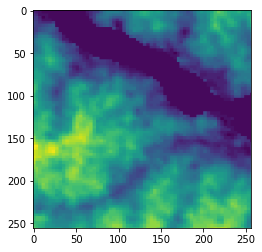

In [28]:
fig, ax = plt.subplots()
ax.imshow(arr_train_X[0][:,:,2])

In [41]:
!nvidia-smi

Tue Mar 16 06:20:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   29C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
from keras.applications.vgg16 import VGG16

vgg16_model1 = VGG16(include_top=False, weights='imagenet', input_shape=(256,256, 3))
#vgg16_model2 = VGG16(include_top=False, weights='imagenet', input_shape=(256,256, 3))
#vgg16_model3 = VGG16(include_top=False, weights='imagenet', input_shape=(256,256, 3))

vgg16_model1.trainable = False
#vgg16_model2.trainable = False
#vgg16_model3.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


In [22]:
from keras.layers import Dense, Concatenate, Input, Lambda, Flatten, Softmax
from keras.models import Model, Sequential

num_channels = 3
input = Input(shape=(256,256, num_channels))

branch_outputs = []

# loop for however many branches you want to use.  (each branch needs 3 channel depth)

# create looping so that vgg16 model input is created ie 256,256,3
print(input.shape)
#out = Lambda(lambda x: x[:,:,:,i:i+3])(input)
#print(out.shape)

# Setting up your layers in each branch: (currently each branch is identical architecture.)
out = Sequential(vgg16_model1)(input)   # use pretrained and loaded vgg16

print(out.shape)
out = Dense(10)(out)
print(out.shape)
out = Flatten()(out)
print(out.shape)
branch_outputs.append(out)

# Concatenating the branches outputs:
#out = Concatenate()(branch_outputs)
#print(out.shape)

# Add final dense layers and softmax
out = Dense(20)(out)
#out = Dense(10)(out)
print(out.shape)
out = Dense(6)(out)
out = Dense(2)(out)
print(out.shape)
out = Softmax()(out)
print(out.shape)

(None, 256, 256, 3)
(None, 8, 8, 512)
(None, 8, 8, 10)
(None, 640)
(None, 20)
(None, 2)
(None, 2)


In [23]:
model = Model(inputs=input, outputs=out)   
model.summary()
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 8, 8, 512)         14714688  
_________________________________________________________________
dense (Dense)                (None, 8, 8, 10)          5130      
_________________________________________________________________
flatten (Flatten)            (None, 640)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                12820     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 126       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

In [24]:
opt = keras.optimizers.Adam(learning_rate=0.05)

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [31]:
import time
test_input = np.random.rand(256,256,3)
test_input = test_input.reshape(1, 256,256, 3)
print(test_input.shape)
t0 = time.time()
print(model.predict(test_input))
print(f"time taken: {time.time()-t0} seconds")

(1, 256, 256, 3)
[[0.1622066  0.83779347]]
time taken: 6.368284225463867 seconds


In [ ]:
t0 = time.time()
model.fit(arr_train_X, arr_train_y, epochs=5, batch_size=64, validation_split = 0.2)#, workers=4, use_multiprocessing=True)
print("Train time:", time.time()-t0)

Epoch 1/5
6/6 [==============================] - 11s 2s/step - loss: 7.6871 - accuracy: 0.2888 - val_loss: 7.6871 - val_accuracy: 0.2892
Epoch 2/5
3/6 [==============>...............] - ETA: 1s - loss: 7.6878 - accuracy: 0.2812

In [33]:
vgg_layer = model.get_layer(name='sequential_2', index=None)
#model.get_layer(name='dense_8', index=None).trainable = False
model.get_layer(name='dense_9', index=None).trainable = False
model.get_layer(name='dense_10', index=None).trainable = False
model.get_layer(name='dense_11', index=None).trainable = False
model.get_layer(name='dense_12', index=None).trainable = False

vgg_layer.trainable = True
model.summary()
opt = keras.optimizers.Adam(learning_rate=0.1)

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
#model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 8, 8, 512)         14714688  
_________________________________________________________________
dense_9 (Dense)              (None, 8, 8, 10)          5130      
_________________________________________________________________
flatten_2 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 20)                12820     
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 126       
_________________________________________________________________
dense_12 (Dense)             (None, 2)                

In [34]:
model.fit(arr_train_X, arr_train_y, epochs=5, batch_size=16, validation_split = 0.2)#, workers=4, use_multiprocessing=True)


Epoch 1/5
9/9 [==============================] - 15s 2s/step - loss: 7.6771 - accuracy: 0.5970 - val_loss: 7.6763 - val_accuracy: 0.5882
Epoch 2/5
9/9 [==============================] - 4s 480ms/step - loss: 7.6771 - accuracy: 0.5970 - val_loss: 7.6763 - val_accuracy: 0.5882
Epoch 3/5
9/9 [==============================] - 4s 481ms/step - loss: 7.6771 - accuracy: 0.5970 - val_loss: 7.6763 - val_accuracy: 0.5882
Epoch 4/5
9/9 [==============================] - 4s 481ms/step - loss: 7.6771 - accuracy: 0.5970 - val_loss: 7.6763 - val_accuracy: 0.5882
Epoch 5/5
9/9 [==============================] - 4s 479ms/step - loss: 7.6771 - accuracy: 0.5970 - val_loss: 7.6763 - val_accuracy: 0.5882


In [25]:
np.mean(arr_train_y)

0.5952380952380952

In [21]:
x = model.predict_on_batch(arr_train_X[:10])
print(x)

[[1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.1937740e-31]
 [1.0000000e+00 1.2457646e-30]
 [1.0000000e+00 3.6220060e-25]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00]]
